## Градиентный бустинг 
### Ноутбук составлен по мотивам лекций профессора Воронцова по ML для МФТИ и ШАД, а также по презентации Tanqi Chen Introduction to boosted trees

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from scipy import stats
from mlxtend.plotting import plot_decision_regions
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_circles

Оставим класс узла дерева из предыдущих ноутбуков. Он не поменяется

In [2]:
class Node:
    def __init__(self, left = None, right = None, value = None, feature = None, feature_val = None):
        self.__left = left
        self.__right = right
        self.__feature = feature
        self.__value = value
        self.__feature_val = feature_val
        
    @property
    def right(self):
        return self.__right
    
    @right.setter
    def right(self, right):
        if isinstance(right, Node):
            self.__right = right
        else:
            print("self.__right can only be an instance of Node")
            
    @property
    def left(self):
        return self.__left
    
    @left.setter
    def left(self, left):
        if isinstance(left, Node):
            self.__left = left
        else:
            print("self.__left can only be an instance of Node")
            
    @property
    def value(self):
        return self.__value
    
    @property
    def feature(self):
        return self.__feature
    
    @property
    def feature_val(self):
        return self.__feature_val

Логика прохода по дереву также не должна измениться:

In [3]:
def DT(root, test_obj):
    node = root
    while node.value is None:
        if test_obj[node.feature] <= node.feature_val:
            node = node.left
        else:
            node = node.right
    return node.value

Реализуем алгоритм градиентного бустинга. Создадим тестовый датасет на 4 признака, как и для Random Forest

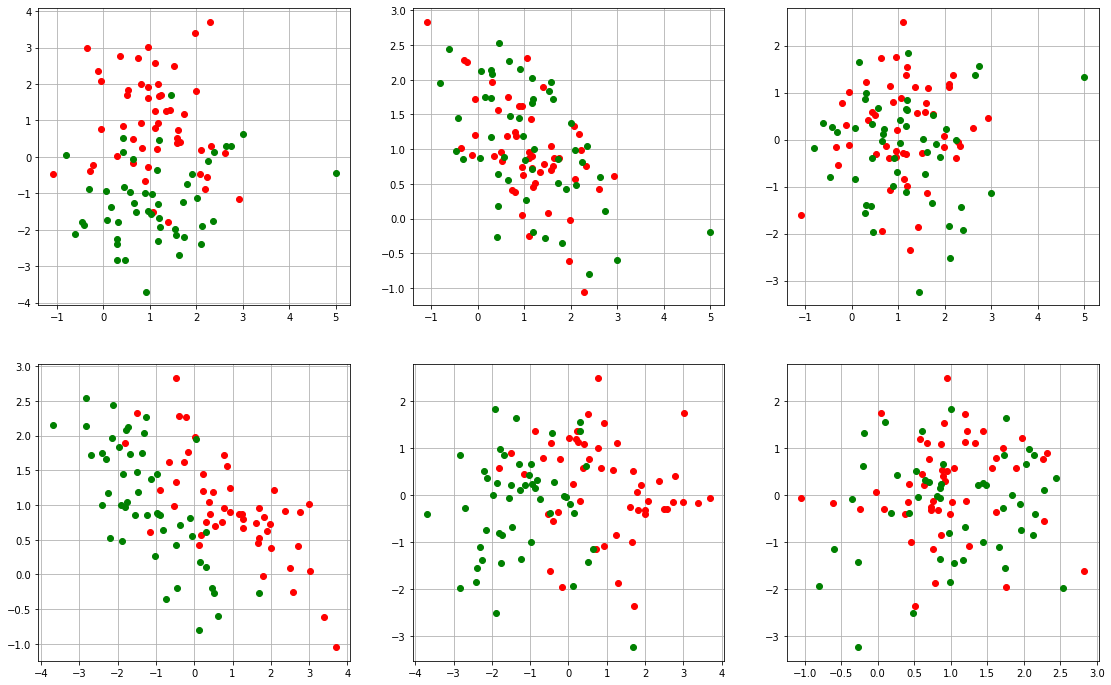

In [4]:
X, Y = make_classification(n_samples=150, n_features=4, 
                           n_informative=3, n_classes=2, 
                           n_redundant=0,
                           n_clusters_per_class=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=50)

fig, gs = plt.figure(figsize=(19, 12)), gridspec.GridSpec(2, 3)

ax = []
for i in range(6):
    ax.append(fig.add_subplot(gs[i]))

ax[0].plot(X_train[np.where(Y_train==0), 0], X_train[np.where(Y_train==0), 1], 'ro')
ax[0].plot(X_train[np.where(Y_train==1), 0], X_train[np.where(Y_train==1), 1], 'go')
ax[0].grid()

ax[1].plot(X_train[np.where(Y_train==0), 0], X_train[np.where(Y_train==0), 2], 'ro')
ax[1].plot(X_train[np.where(Y_train==1), 0], X_train[np.where(Y_train==1), 2], 'go')
ax[1].grid()

ax[2].plot(X_train[np.where(Y_train==0), 0], X_train[np.where(Y_train==0), 3], 'ro')
ax[2].plot(X_train[np.where(Y_train==1), 0], X_train[np.where(Y_train==1), 3], 'go')
ax[2].grid()

ax[3].plot(X_train[np.where(Y_train==0), 1], X_train[np.where(Y_train==0), 2], 'ro')
ax[3].plot(X_train[np.where(Y_train==1), 1], X_train[np.where(Y_train==1), 2], 'go')

ax[3].grid()

ax[4].plot(X_train[np.where(Y_train==0), 1], X_train[np.where(Y_train==0), 3], 'ro')
ax[4].plot(X_train[np.where(Y_train==1), 1], X_train[np.where(Y_train==1), 3], 'go')
ax[4].plot(X_train[np.where(Y_train==2), 1], X_train[np.where(Y_train==2), 3], 'bo')
ax[4].grid()

ax[5].plot(X_train[np.where(Y_train==0), 2], X_train[np.where(Y_train==0), 3], 'ro')
ax[5].plot(X_train[np.where(Y_train==1), 2], X_train[np.where(Y_train==1), 3], 'go')
ax[5].plot(X_train[np.where(Y_train==2), 2], X_train[np.where(Y_train==2), 3], 'bo')
ax[5].grid()

plt.show()

Что понадобится для алгоритма: для перебора признаков деревьев и выбора наилучшего сплита, как и в ID3, необходимо реализовать критерий поиска оптимальной структуры. Для этого нужно задаться функцией потерь, посчитать от нее первую и вторую производную от выхода классификатора на предыдущем шаге, и, далее, посчитать целевую функцию. 

Как выглядит целевая функция для поиска оптимального дерева:

### $$ Obj = -\frac{1}{2}\sum_{j=1}^T(\frac{G_j^2}{H_j + \lambda}) + \gamma T,$$
где T - число листьев в дереве,

$\gamma$ - параметр, регулирующий наказание за сложность дерева с точки зрения количества листов,

$\lambda$ - параметр, регулирующий наказание за сложность дерева по сумме L2-норм весов в листах дерева,

#### $G_i = \sum_{i \in I_j}{g_i}$, $H_i = \sum_{i \in I_j}{h_i}$ - 
суммы первых и вторых производных от функции потерь

#### $g_i = \frac{\partial l(y_i, \hat{y_i}^{(t-1)})}{\partial \hat{y_i}^{(t-1)}}$, $h_i = \frac{\partial^2 l(y_i, \hat{y_i}^{(t-1)})}{\partial{\hat{y_i}^{(t-1)}}^2}$,
которые рассчитываются для каждого элемента обучающей выборки i, попадающего множество объектов $I_j$, относимого классификатором к листу j

Для простоты возьмем сначала квадратичную функцию потерь, после можно будет попробовать NLLLoss.

In [5]:
def sqr1(y, y_hat): # первая производная
    return y_hat - y

def sqr2(y, y_hat): # вторая производная
    return y - y + 1

В чем неудобство целевой функции - она считается от готового дерева. Т.е., сначала нужно построить дерево, потом оценить, насколько оно удачно, по целевой функции, потом построить еще дерево, оценить, сравнить и т.д. Но структур деревьев может быть бесконечно много, поэтому нужен другой алгоритм построения дерева. 
Можно оценивать каждый сплит, как и в алгоритме ID3: пробовать делить датасет на две части по какому-то признаку и оценивать, становится ли ниже переменная, стоящая в целевой функции под знаком суммы. 
### $$ Gain = \frac{G_L^2}{H_L + \lambda} + \frac{G_R^2}{H_R + \lambda} - \frac{(G_L + G_R)^2}{H_L + H_R + \lambda} - \gamma$$
Первые два слагаемых - значение целевой функции в каждом из получившихся подмножеств в рассматриваемой паре листов, справа - это же значение до разбиения, минус гамма - плата за создание нового листа. 

In [6]:
def gain(xl, yl, yl_hat, xr, yr, yr_hat, gamma, lmbd, g = sqr1, h = sqr2, debug = 0):
    Gl, Hl = g(yl, yl_hat).sum(), h(yl, yl_hat).sum()
    Gr, Hr = g(yr, yr_hat).sum(), h(yr, yr_hat).sum()
    if debug == 2: print(Gl, Gr, Hl, Hr)
    result = Gl**2 / (Hl + lmbd) + Gr**2 / (Hr + lmbd) - (Gl + Gr)**2 / (Hl + Hr + lmbd) - gamma
    if debug == 2: print(result)
    return result, Gl, Hl, Gr, Hr

Функция создания нового узла очень похожа на ID3, так как используется тот же критерий gain, только в данном случае не снижение энтропии, а снижение целевой функции. Вес листа рассчитывается по формуле 

### $$w = \frac{-G}{H + \lambda}$$

In [7]:
def nextNode(X_train, Y_train, Y_hat = None, min_gain = 0, gamma = 0.1, lmbd = 0.1, 
             max_weight = None, g = sqr1, h = sqr2, orientation = "root", level = 0, debug = 0):
    if Y_hat is None:
        Y_hat = np.zeros(Y_train.shape)
    max_gain = -1e3
    Gl_= Gr_ = Hl_ = Hr_ = None
    X_left_ = Y_left_ = Y_hat_left_ = X_right_ = Y_right_ = Y_hat_right_ = None
    feature_ = val_ = None
    
    tab = "---" * level
    for feature in range(X_train.shape[1]):
        if debug == 2: print(f"\n *** working with feature {feature} *** \n")
        order = np.argsort(X_train[:, feature])
        X_sorted, Y_sorted, Y_hat_sorted = X_train[order], Y_train[order], Y_hat[order]
        for i, val in enumerate(X_sorted[:, feature][1: -1]):
            X_left, Y_left, Y_hat_left = X_sorted[:i], Y_sorted[:i], Y_hat_sorted[:i]
            X_right, Y_right, Y_hat_right = X_sorted[i:], Y_sorted[i:], Y_hat_sorted[i:]
            curr_gain, Gl, Hl, Gr, Hr = gain(X_left, Y_left, Y_hat_left, X_right, Y_right, Y_hat_right, gamma, lmbd, g, h)
            if curr_gain > max_gain:
                max_gain = curr_gain
                Gl_, Hl_, Gr_, Hr_ = Gl, Hl, Gr, Hr
                X_left_, Y_left_, Y_hat_left_, X_right_, Y_right_, Y_hat_right_ = X_left, Y_left, Y_hat_left, X_right, Y_right, Y_hat_right
                feature_, val_ = feature, val
                if debug == 2: print("new max_gain found:", max_gain)
                if debug == 2: print(f"feature = {feature}, feature val = {val}")
                
    if max_gain < min_gain:
        G, H = g(Y_train, Y_hat).sum(), h(Y_train, Y_hat).sum()
        w = -G / (H + lmbd)
        if max_weight and abs(w) > max_weight:
            if w > 0:
                w = max_weight
            else:
                w = -max_weight
        if debug == 1: print(f"{tab} level {level}: {orientation} creating leaf node with weight {w}")
        level += 1
        return Node(value = w)
        
    wl = -Gl / (Hl + lmbd)
    wr = -Gr / (Hr + lmbd)
    if debug == 1: print(f"{tab} level {level}: {orientation} creating split with feature {feature_} val = {val_}")
    level += 1
    return Node(left = nextNode(X_left_, Y_left_, Y_hat = Y_hat_left_, min_gain = min_gain, gamma = gamma, lmbd = lmbd, 
             max_weight = max_weight, g = g, h = h, orientation = "left", level = level, debug = debug),
                right = nextNode(X_right_, Y_right_, Y_hat = Y_hat_right_, min_gain = min_gain, gamma = gamma, lmbd = lmbd, 
             max_weight = max_weight, g = g, h = h, orientation = "right", level = level, debug = debug),
                feature  = feature_, feature_val = val_)

Создадим для пробы одно решающее дерево и посмотрим, насколько успешно оно будет классифицировать наш тестовый датасет без ансамбля, сам.

In [8]:
testnode = nextNode(X_train, Y_train, min_gain = 0, gamma = 0.1, lmbd = 0.1, g = sqr1, h = sqr2, debug = 1)

 level 0: root creating split with feature 1 val = -0.5394659530666706
--- level 1: left creating split with feature 0 val = 2.3540619182581715
------ level 2: left creating split with feature 3 val = 0.6592177800493841
--------- level 3: left creating leaf node with weight 0.9963099630996309
--------- level 3: right creating split with feature 3 val = 0.6711422088249939
------------ level 4: left creating leaf node with weight -0.0
------------ level 4: right creating split with feature 2 val = 2.1399635329917093
--------------- level 5: left creating leaf node with weight 0.9803921568627452
--------------- level 5: right creating leaf node with weight 0.6451612903225806
------ level 2: right creating leaf node with weight 0.3225806451612903
--- level 1: right creating split with feature 0 val = 2.7361371940107517
------ level 2: left creating split with feature 1 val = 0.7279467437042471
--------- level 3: left creating split with feature 2 val = 0.9883976085686778
------------ level

In [9]:
Y_hat = [1 if DT(testnode, y) > 0.5 else 0 for y in X_test]
np.where(Y_hat != Y_test)[0].shape[0]

9

Реализуем классификатор GB. Алгоритм требует стартовой инициализации оценки $ \hat{y_i}^{(0)}$. В функции ниже используется инициализация нулевыми значениями, но можно пробовать применять и случайную инициализацию в диапазоне [0, 1] - создадим для этого дерево, возвращающее такие значения. Оно будет включено нулевым элементом в ансамбль.

In [10]:
class RandNode:
    def __init__(self):
        self.__value = None
            
    @property
    def value(self):
        return np.random.uniform(low = 0.0, high = 1.0)

In [11]:
class GB:
    def __init__(self, X_train, Y_train, gamma = 0.1, lmbd = 0.1, max_weight = None, min_gain = 0, g = sqr1, h = sqr2, T = 10, step = 0.1, debug = 0):
        self.X_train = X_train
        self.Y_train = Y_train
        self.gamma = gamma
        self.lmbd = lmbd 
        self.max_weight = max_weight
        self.min_gain = min_gain
        self.g = g
        self.h = h
        self.debug = debug
        self.T = T
        self.step = step
        self.trees = []
        
    def fit(self):
        self.trees = []
        
        tree0 = Node(value = 0.0)
        # tree0 = RandNode()

        self.trees.append(tree0)
        for t in range(self.T):
            if self.debug == 1: print("building tree", len(self.trees) - 1)
            Y_hat = self.predict_train(self.X_train)
            tree = nextNode(X_train, Y_train, Y_hat = Y_hat, min_gain = self.min_gain, 
                            gamma = self.gamma, lmbd = self.lmbd, max_weight = self.max_weight, g = self.g, h = self.h, 
                            orientation = "root", level = 0, debug = self.debug)
            self.trees.append(tree)
            
    def predict_train(self, X_test): 
        # в тренировке ансамбля необходимо на каждой итерации
        # делать оценки текущим состоянием ансамбля - будем использовать для этого predict_train
        result = []
        for x in X_test:
            result.append(np.array([self.step * DT(tree, x) for tree in self.trees]).sum())
        return np.array(result)
    
    def predict(self, X_test):
        # а это уже классический предикт, который возвращает классы, а не веса.
        result = []
        for x in X_test:
            metric = np.array([self.step * DT(tree, x) for tree in self.trees]).sum()
            if metric > 0.5:
                result.append(1)
            else:
                result.append(0)
        return np.array(result)

Попробуем с дефолтными параметрами без всякого тюнинга на 30 деревьях на датасете с четырьмя признаками

In [12]:
my_GB = GB(X_train, Y_train, T = 30)
my_GB.fit()
Y_hat = my_GB.predict(X_test)
np.where(Y_hat != Y_test)[0].shape[0]

12

In [13]:
sk_GB = GradientBoostingClassifier(n_estimators=30)
sk_GB.fit(X_train, Y_train)
Y_hat = sk_GB.predict(X_test)
np.where(Y_hat != Y_test)[0].shape[0]

8

Теперь попробуем на датасете с двумя признаками, чтобы отрисовать plot_decision_regions

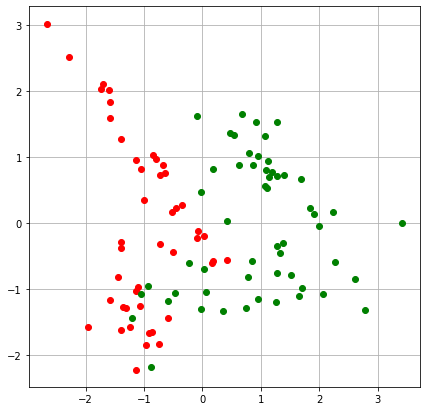

In [47]:
X, Y = make_classification(n_samples=150, n_features=2, 
                           n_informative=2, n_classes=2, 
                           n_redundant=0,
                           n_clusters_per_class=2)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=50)

fig = plt.figure(figsize=(7, 7))

plt.plot(X_train[np.where(Y_train==0), 0], X_train[np.where(Y_train==0), 1], 'ro')
plt.plot(X_train[np.where(Y_train==1), 0], X_train[np.where(Y_train==1), 1], 'go')
plt.grid()

plt.show()

In [48]:
my_GB = GB(X_train, Y_train, T = 30)
my_GB.fit()

In [49]:
Y_hat = my_GB.predict(X_test)
np.where(Y_hat != Y_test)[0].shape[0]

3

In [50]:
sk_GB = GradientBoostingClassifier(n_estimators=30)
sk_GB.fit(X_train, Y_train)

GradientBoostingClassifier(n_estimators=30)

In [51]:
Y_hat = sk_GB.predict(X_test)
np.where(Y_hat != Y_test)[0].shape[0]

4

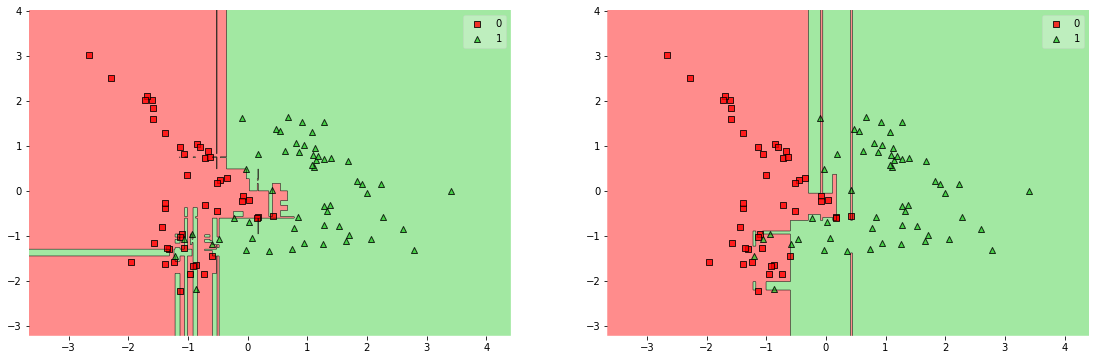

In [52]:
fig, gs = plt.figure(figsize=(19, 6)), gridspec.GridSpec(1, 2)

ax = []
for i in range(2):
    ax.append(fig.add_subplot(gs[i]))
    
plot_decision_regions(X_train, Y_train, my_GB, ax=ax[0], colors = 'red,limegreen,blue,gray,cyan')
plot_decision_regions(X_train, Y_train, sk_GB, ax=ax[1], colors = 'red,limegreen,blue,gray,cyan')

plt.show()

Попробуем увеличить плату за создание нового листа, разделяющая поверхность должна стать более однородной

In [53]:
my_GB = GB(X_train, Y_train, T = 30, gamma = 0.5, step = 0.1, lmbd = 0.1)
my_GB.fit()

In [54]:
sk_GB = GradientBoostingClassifier(n_estimators=30)
sk_GB.fit(X_train, Y_train)

GradientBoostingClassifier(n_estimators=30)

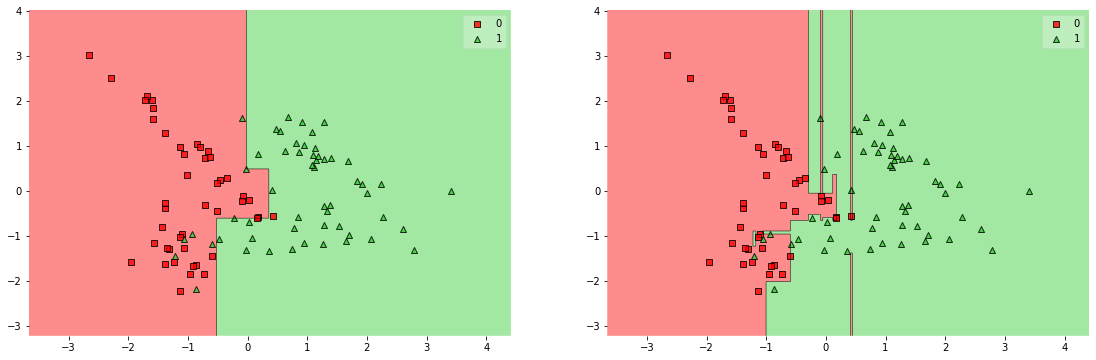

In [55]:
fig, gs = plt.figure(figsize=(19, 6)), gridspec.GridSpec(1, 2)

ax = []
for i in range(2):
    ax.append(fig.add_subplot(gs[i]))
    
plot_decision_regions(X_train, Y_train, my_GB, ax=ax[0], colors = 'red,limegreen,blue,gray,cyan')
plot_decision_regions(X_train, Y_train, sk_GB, ax=ax[1], colors = 'red,limegreen,blue,gray,cyan')

plt.show()

Попробуем с NLLLoss:

In [56]:
def sgm(x):
    return 1 / (1 + np.exp(-x))

In [57]:
def nlll1(y, y_hat):
    return sgm(y_hat) - y

def nlll2(y, y_hat):
    return sgm(y_hat) * (1 - sgm(y_hat))

In [58]:
my_GB = GB(X_train, Y_train, T = 100, step = 0.1, lmbd = 0.3, gamma = 0.1, g = nlll1, h = nlll2, debug = 0)
my_GB.fit()

In [59]:
Y_hat = my_GB.predict(X_test)
np.where(Y_hat != Y_test)[0].shape[0]

6

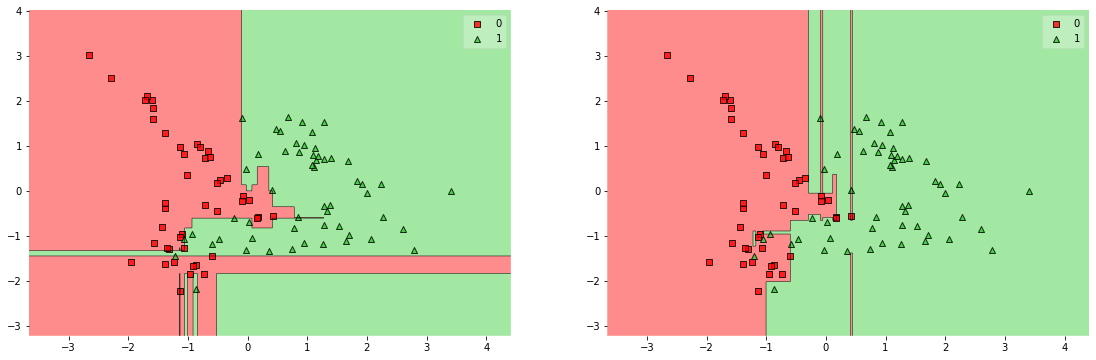

In [60]:
fig, gs = plt.figure(figsize=(19, 6)), gridspec.GridSpec(1, 2)

ax = []
for i in range(2):
    ax.append(fig.add_subplot(gs[i]))
    
plot_decision_regions(X_train, Y_train, my_GB, ax=ax[0], colors = 'red,limegreen,blue,gray,cyan')
plot_decision_regions(X_train, Y_train, sk_GB, ax=ax[1], colors = 'red,limegreen,blue,gray,cyan')

plt.show()

Теперь классика - окружности

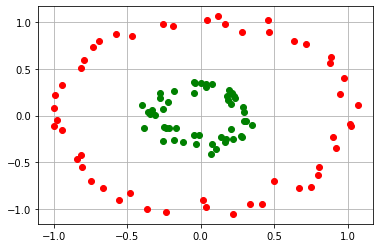

In [61]:
X_train, Y_train = make_circles(factor=0.3, noise=0.05)

plt.plot(X_train[np.where(Y_train==0), 0], X_train[np.where(Y_train==0), 1], 'ro')
plt.plot(X_train[np.where(Y_train==1), 0], X_train[np.where(Y_train==1), 1], 'go')
plt.grid()

plt.show()

In [62]:
my_GB = GB(X_train, Y_train, T = 30, step = 0.3, g = nlll1, h = nlll2, lmbd = 0.3, gamma = 0.0001, debug = 0)
my_GB.fit()

In [63]:
sk_GB = GradientBoostingClassifier(n_estimators=30, learning_rate=1)
sk_GB.fit(X_train, Y_train)

GradientBoostingClassifier(learning_rate=1, n_estimators=30)

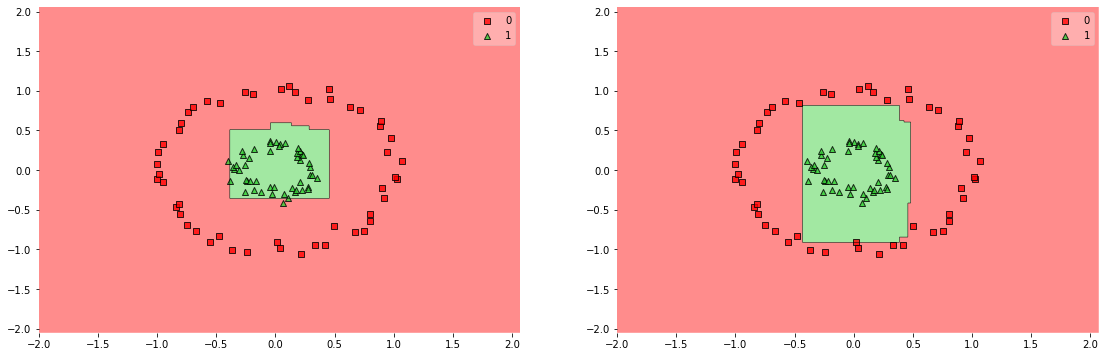

In [64]:
fig, gs = plt.figure(figsize=(19, 6)), gridspec.GridSpec(1, 2)

ax = []
for i in range(2):
    ax.append(fig.add_subplot(gs[i]))
    
plot_decision_regions(X_train, Y_train, my_GB, ax=ax[0], colors = 'red,limegreen,blue,gray,cyan')
plot_decision_regions(X_train, Y_train, sk_GB, ax=ax[1], colors = 'red,limegreen,blue,gray,cyan')

plt.show()